In [1]:
using Interpolations
using DelimitedFiles
using Cubature
using Plots
using LaTeXStrings

In [2]:
kpk = readdlm("test_pk.txt", comments=true)
pk_itp = interpolate((kpk[:,1],), kpk[:,2], Gridded(Linear()));

In [3]:
b = 2
f = 0.7
pk2d = (μ, k) -> (b + μ^2*f)^2*pk_itp(k)

#9 (generic function with 1 method)

In [4]:
kp = (k, μ, αV, ϵ) -> k*sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))
μp = (k, μ, αV, ϵ) -> μ*αV*ϵ/sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))

#13 (generic function with 1 method)

In [5]:
L0 = x -> 1
L2 = x -> (3*x^2 - 1)/2
L4 = x -> (35*x^4 - 30*x^2 + 3)/8

#19 (generic function with 1 method)

In [6]:
function pkprime(kgrid, weight, αV, ϵ)
    Nk = size(kgrid)[1]
    pp = zeros(Nk)
    for i in 1:Nk
        pp[i] = hquadrature(x -> pk2d(μp(kgrid[i], x, αV, ϵ), kp(kgrid[i], x, αV, ϵ))*weight(x), -1, 1, reltol=1e-4)[1]
    end
    return pp
end

pkprime (generic function with 1 method)

In [7]:
function pell(kgrid, αV, ϵ)
    p0 = pkprime(kgrid, L0, αV, ϵ)*1/2
    p2 = pkprime(kgrid, L2, αV, ϵ)*5/2
    p4 = pkprime(kgrid, L4, αV, ϵ)*9/2
    return p0, p2, p4
end
kgrid = collect(range(0.00, 0.20, step=0.01))
αV = 1.00
ϵ = 1.00
p0ref, p2ref, p4ref = pell(kgrid, αV, ϵ)
p0refp, p2refp, p4refp = pell(kgrid .+ 0.001, αV, ϵ)
dp0 = (p0refp .- p0ref)/0.001.*kgrid
dp2 = (p2refp .- p2ref)/0.001.*kgrid
dp4 = (p4refp .- p4ref)/0.001.*kgrid;

In [8]:
function pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
    δα = αV - 1
    δϵ = ϵ - 1
    p0th = p0ref + dp0*δα + (1/5)*dp2*δϵ + (3/5)*p2ref*δϵ
    p2th = p2ref + dp2*δα + (1)*dp0*δϵ + (2/7)*dp2*δϵ + (2/7)*dp4*δϵ + (3/7)*p2ref*δϵ + (10/7)*p4ref*δϵ
    p4th = p4ref + dp4*δα + (18/35)*dp2*δϵ + (20/77)*dp4*δϵ + (-36/35)*p2ref*δϵ + (30/77)*p4ref*δϵ
    return p0th, p2th, p4th
end
αV = 1.01
ϵ = 1.00
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot(kgrid, p0./p0ref, color=:red, label=L"\alpha_V \pm 1\%", layout=(3,1), size=(600, 800), dpi=500)
scatter!(kgrid, p0th./p0ref, color=:red, label=:none, subplot=1, xaxis=:false)
plot!(kgrid, p2./p2ref, color=:red, label=L"\alpha_V \pm 1\%", subplot=2)
scatter!(kgrid, p2th./p2ref, color=:red, label=:none, subplot=2, xaxis=:false)
plot!(kgrid, p4./p4ref, color=:red, label=L"\alpha_V \pm 1\%", subplot=3)
scatter!(kgrid, p4th./p4ref, color=:red, label=:none, subplot=3)
αV = 0.99
ϵ = 1.00
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot!(kgrid, p0./p0ref, color=:red, label=:none, subplot=1)
scatter!(kgrid, p0th./p0ref, color=:red, label=:none, subplot=1)
plot!(kgrid, p2./p2ref, color=:red, label=:none,subplot=2)
scatter!(kgrid, p2th./p2ref, color=:red, label=:none,subplot=2)
plot!(kgrid, p4./p4ref, color=:red, label=:none,subplot=3)
scatter!(kgrid, p4th./p4ref, color=:red, label=:none,subplot=3)
αV = 1.00
ϵ = 1.01
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot!(kgrid, p0./p0ref, color=:blue, label=L"\alpha_\epsilon \pm 1\%", subplot=1)
scatter!(kgrid, p0th./p0ref, color=:blue, label=:none, subplot=1)
plot!(kgrid, p2./p2ref, color=:blue, label=L"\alpha_\epsilon \pm 1\%", subplot=2)
scatter!(kgrid, p2th./p2ref, color=:blue, label=:none, subplot=2)
plot!(kgrid, p4./p4ref, color=:blue, label=L"\alpha_\epsilon \pm 1\%", subplot=3)
scatter!(kgrid, p4th./p4ref, color=:blue, label=:none, subplot=3)
αV = 1.00
ϵ = 0.99
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot!(kgrid, p0./p0ref, color=:blue, label=:none, legend=:topleft, subplot=1)
scatter!(kgrid, p0th./p0ref, color=:blue, label=:none, subplot=1)
plot!(kgrid, p2./p2ref, color=:blue, label=:none, legend=:topleft, subplot=2)
scatter!(kgrid, p2th./p2ref, color=:blue, label=:none, subplot=2)
plot!(kgrid, p4./p4ref, color=:blue, label=:none, legend=:topleft, subplot=3)
scatter!(kgrid, p4th./p4ref, color=:blue, label=:none, subplot=3)
plot!(xlabel="wavenumber in Mpc/h", ylabel=L"P_4/P^\mathrm{ref}_4", subplot=3)
plot!(ylabel=L"P_2/P^\mathrm{ref}_2", subplot=2)
plot!(ylabel=L"P_0/P^\mathrm{ref}_0", subplot=1)
plot!(xrange=(0,0.20), yrange=(0.97,1.03),grid=true,tickfontsize=12,fontfamily="Arial",minorticks=:true,minorgrid=true, subplot=1)
plot!(xrange=(0,0.20), yrange=(0.94,1.06), yticks=([0.94, 0.96, 0.98, 1.00, 1.02, 1.04, 1.06]), grid=true,fontfamily="Arial",tickfontsize=12,minorticks=:true,minorgrid=true, subplot=2)
plot!(xrange=(0,0.20), yrange=(0.5,1.5),grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true,guidefontsize=14,tickfontsize=12,subplot=3)
annotate!(0.04, 0.975, "Monopole", fontfamily="Arial", subplot=1)
annotate!(0.04, 0.95, "Quadrupole", fontfamily="Arial", subplot=2)
annotate!(0.04, 0.60, "Hexadecapole", fontfamily="Arial", subplot=3)
savefig("Pap.pdf")


In [10]:
function solve_triangular_geometry(μ1, ϕ, k1, k2, k3)
    μ12 = (k1^2 + k2^2 - k3^2)/(2*k1*k2)
    μ31 = (k3^2 + k1^2 - k2^2)/(2*k3*k1)
    μ23 = (k2^2 + k3^2 - k1^2)/(2*k2*k3)
    if μ1^2 > 1
        ν1 = 0
    else
        ν1 = sqrt(1 - μ1^2)
    end
    if μ12^2 > 1
        ν12 = 0
    else
        ν12 = sqrt(1 - μ12^2)
    end
    μ3 = - μ1*μ12 - ν1*ν12*cos(ϕ)
    μ2 = -(μ1*k1 + μ3*k3)/k2
    if μ2^2 > 1
        ν2 = 0
    else
        ν2 = sqrt(1 - μ2^2)
    end
    if μ3^2 > 1
        ν3 = 0
    else
        ν3 = sqrt(1 - μ3^2)
    end
    return μ2, μ3, μ12, μ23, μ31, ν1, ν2, ν3, ν12
end

function tree_level_bk(μ1, ϕ, k1, k2, k3, b1, b2, f, pk)

    pk1 = pk(k1)
    pk2 = pk(k2)
    pk3 = pk(k3)

    μ2, μ3, μ12, μ23, μ31, _, _, _, _ = solve_triangular_geometry(μ1, ϕ, k1, k2, k3)
 
    Z1k1 = b1 + f*μ1^2
    Z1k2 = b1 + f*μ2^2
    Z1k3 = b1 + f*μ3^2
 
    F12 = 5/7 + μ12/2*(k1/k2 + k2/k1) + 2/7*μ12^2
    F23 = 5/7 + μ23/2*(k2/k3 + k3/k2) + 2/7*μ23^2
    F31 = 5/7 + μ31/2*(k3/k1 + k1/k3) + 2/7*μ31^2
 
    G12 = 3/7 + μ12/2*(k1/k2 + k2/k1) + 4/7*μ12^2
    G23 = 3/7 + μ23/2*(k2/k3 + k3/k2) + 4/7*μ23^2
    G31 = 3/7 + μ31/2*(k3/k1 + k1/k3) + 4/7*μ31^2
 
    Z2k12 = b2/2. + b1*F12 + f*μ3^2*G12
    Z2k12 -= f*μ3*k3/2*(μ1/k1*Z1k2 + μ2/k2*Z1k1)
    Z2k23 = b2/2. + b1*F23 + f*μ1^2*G23
    Z2k23 -= f*μ1*k1/2*(μ2/k2*Z1k3 + μ3/k3*Z1k2)
    Z2k31 = b2/2. + b1*F31 + f*μ2^2*G31
    Z2k31 -= f*μ2*k2/2*(μ3/k3*Z1k1 + μ1/k1*Z1k3)

    Bi = Z2k12*Z1k1*Z1k2*pk1*pk2
    Bi += Z2k23*Z1k2*Z1k3*pk2*pk3
    Bi += Z2k31*Z1k3*Z1k1*pk3*pk1
 
    return 2*Bi 
end

function bk5d(μ, ϕ, k1, k2, k3)
    return tree_level_bk(μ, ϕ, k1, k2, k3, 2, 0.6, 0.7, pk_itp)
end

bk5d (generic function with 1 method)

In [11]:
function k1t(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    μ2, μ3, μ12, μ23, μ31, ν, ν2, ν3, ν12 = solve_triangular_geometry(μ, ϕ, k1, k2, k3)
    k1x = 0
    k1y = k1*ν
    k1z = k1*μ
    return sqrt((k1x^2+k1y^2)*Aperp^2 + k1z^2*Apar^2)
end
function k2t(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    μ2, μ3, μ12, μ23, μ31, ν1, ν2, ν3, ν12 = solve_triangular_geometry(μ, ϕ, k1, k2, k3)
    k2par = μ2*k2
    k2per = ν2*k2
    return sqrt(k2per^2*Aperp^2 + k2par^2*Apar^2)
end
function k3t(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    μ2, μ3, μ12, μ23, μ31, ν1, ν2, ν3, ν12 = solve_triangular_geometry(μ, ϕ, k1, k2, k3)
    k3par = μ3*k3
    k3per = ν3*k3
    return sqrt(k3per^2*Aperp^2 + k3par^2*Apar^2)
end
function μt(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    μ2, μ3, μ12, μ23, μ31, ν, ν2, ν3, ν12 = solve_triangular_geometry(μ, ϕ, k1, k2, k3)
    k1x = 0
    k1y = k1*ν
    k1z = k1*μ
    return k1z*Apar/sqrt((k1x^2+k1y^2)*Aperp^2 + k1z^2*Apar^2)
end
function ϕt(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    return ϕ
end

ϕt (generic function with 1 method)

In [12]:
function Y00(x)
    return 1/2/sqrt(π)
end
function Y20(x)
    return sqrt(5)/4/sqrt(π)*(3*x.^2 .-1)
end
function Y40(x)
    return 3/16/sqrt(π)*(35*x.^4 .-30*x.^2 .+3)
end

function bk5d_int(k1, k2, k3, μ, ϕ, αV, ϵ)
    y1 = k1t(k1, k2, k3, μ, ϕ, αV, ϵ)
    y2 = k2t(k1, k2, k3, μ, ϕ, αV, ϵ)
    y3 = k3t(k1, k2, k3, μ, ϕ, αV, ϵ)
    y4 = μt(k1, k2, k3, μ, ϕ, αV, ϵ)
    y5 = ϕ
    return bk5d(y4, y5, y1, y2, y3)
end

function blm(k1, k2, k3, αV, ϵ, W)
    Nk = size(k1)[1]
    pp = zeros(Nk)
    for i in 2:Nk
        pp[i] = hcubature(x -> 
            bk5d_int(k1[i], k2[i], k3[i], x[1], x[2], αV, ϵ)*W(x[1]), [-1, 0], [1, 2*π], reltol=1e-8)[1]
    end
    return pp
end

function b00(k1, k2, k3, αV, ϵ)
    return blm(k1, k2, k3, αV, ϵ, Y00)
end
function b20(k1, k2, k3, αV, ϵ)
    return blm(k1, k2, k3, αV, ϵ, Y20)
end
function b40(k1, k2, k3, αV, ϵ)
    return blm(k1, k2, k3, αV, ϵ, Y40)
end

b40 (generic function with 1 method)

In [13]:
B00fid = b00(kgrid, kgrid, kgrid, 1.00, 1.00);
B20fid = b20(kgrid, kgrid, kgrid, 1.00, 1.00);
B40fid = b40(kgrid, kgrid, kgrid, 1.00, 1.00);

MethodError: MethodError: no method matching ^(::typeof(k1t), ::Int64)
Closest candidates are:
  ^(!Matched::Union{AbstractChar, AbstractString}, ::Integer) at strings/basic.jl:718
  ^(!Matched::Complex{var"#s77"} where var"#s77"<:AbstractFloat, ::Integer) at complex.jl:818
  ^(!Matched::Complex{var"#s77"} where var"#s77"<:Integer, ::Integer) at complex.jl:820
  ...

In [14]:
# log derivatives
dB00k1 = (b00(kgrid*(1 + 1e-6), kgrid, kgrid, 1.00, 1.00) .- b00(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB00k2 = (b00(kgrid, kgrid*(1 + 1e-6), kgrid, 1.00, 1.00) .- b00(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB00k3 = (b00(kgrid, kgrid, kgrid*(1 + 1e-6), 1.00, 1.00) .- b00(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB20k1 = (b20(kgrid*(1 + 1e-6), kgrid, kgrid, 1.00, 1.00) .- b20(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB20k2 = (b20(kgrid, kgrid*(1 + 1e-6), kgrid, 1.00, 1.00) .- b20(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB20k3 = (b20(kgrid, kgrid, kgrid*(1 + 1e-6), 1.00, 1.00) .- b20(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB40k1 = (b40(kgrid*(1 + 1e-6), kgrid, kgrid, 1.00, 1.00) .- b40(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB40k2 = (b40(kgrid, kgrid*(1 + 1e-6), kgrid, 1.00, 1.00) .- b40(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB40k3 = (b40(kgrid, kgrid, kgrid*(1 + 1e-6), 1.00, 1.00) .- b40(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;

MethodError: MethodError: no method matching ^(::typeof(k1t), ::Int64)
Closest candidates are:
  ^(!Matched::Union{AbstractChar, AbstractString}, ::Integer) at strings/basic.jl:718
  ^(!Matched::Complex{var"#s77"} where var"#s77"<:AbstractFloat, ::Integer) at complex.jl:818
  ^(!Matched::Complex{var"#s77"} where var"#s77"<:Integer, ::Integer) at complex.jl:820
  ...

In [15]:
b00list = zeros(4, Nk);
b20list = zeros(4, Nk);
b40list = zeros(4, Nk);
b00thlist = zeros(4, Nk);
b20thlist = zeros(4, Nk);
b40thlist = zeros(4, Nk);

In [16]:
for i in 1:4
    b00list[i,:] = b00(kgrid, kgrid, kgrid, αVlist[i], ϵlist[i])
    b20list[i,:] = b20(kgrid, kgrid, kgrid, αVlist[i], ϵlist[i])
    b40list[i,:] = b40(kgrid, kgrid, kgrid, αVlist[i], ϵlist[i])
end

In [17]:
function blmtheory(αV, ϵ, α12, α31)
    δαV = 1 - αV
    δϵ = 1 - ϵ

    b0th = B00fid
    b0th += (dB00k1 + dB00k2 + dB00k3)*δαV
    b0th += dB20k1/sqrt(5)*δϵ 
    b0th += dB20k2.*(1 + 3*cos(2*α12))/4/sqrt(5)*δϵ
    b0th += dB20k3.*(1 + 3*cos(2*α31))/4/sqrt(5)*δϵ
    b0th += B20fid*3/sqrt(5)*δϵ
   
    b2th = B20fid
    b2th += (dB20k1 + dB20k2 + dB20k3)*δαV
    b2th += (dB00k1/sqrt(5) + dB20k1*2/7 + dB40k1*6/7/sqrt(5))*δϵ
    b2th += (dB00k2/4/sqrt(5) + dB20k2/14 + dB40k2*3/14/sqrt(5))*(1 + 3*cos(2*α12))*δϵ
    b2th += (dB00k3/4/sqrt(5) + dB20k3/14 + dB40k3*3/14/sqrt(5))*(1 + 3*cos(2*α31))*δϵ
    b2th += (B20fid*3/7 + B40fid*6/sqrt(5)/7)*δϵ

    b4th = B40fid
    b4th += (dB40k1 + dB40k2 + dB40k3)*δαV
    b4th += (dB20k1*6/7/sqrt(5) + dB40k1*20/77)*δϵ
    b4th += (dB20k2*3/4/sqrt(5) + dB40k2*5/77)*(1 + 3*cos(2*α12))*δϵ
    b4th += (dB20k3*3/14/sqrt(5) + dB40k3*5/77)*(1 + 3*cos(2*α31))*δϵ
    b4th += (B20fid*(-12/7/sqrt(5)) + B40fid*(30/77))*δϵ

    return b0th, b2th, b4th
end


blmtheory (generic function with 1 method)

In [18]:
for i in 1:4
    b00thlist[i,:], b20thlist[i,:], b40thlist[i,:] = blmtheory(αVlist[i], ϵlist[i], π/3, π/3)
end

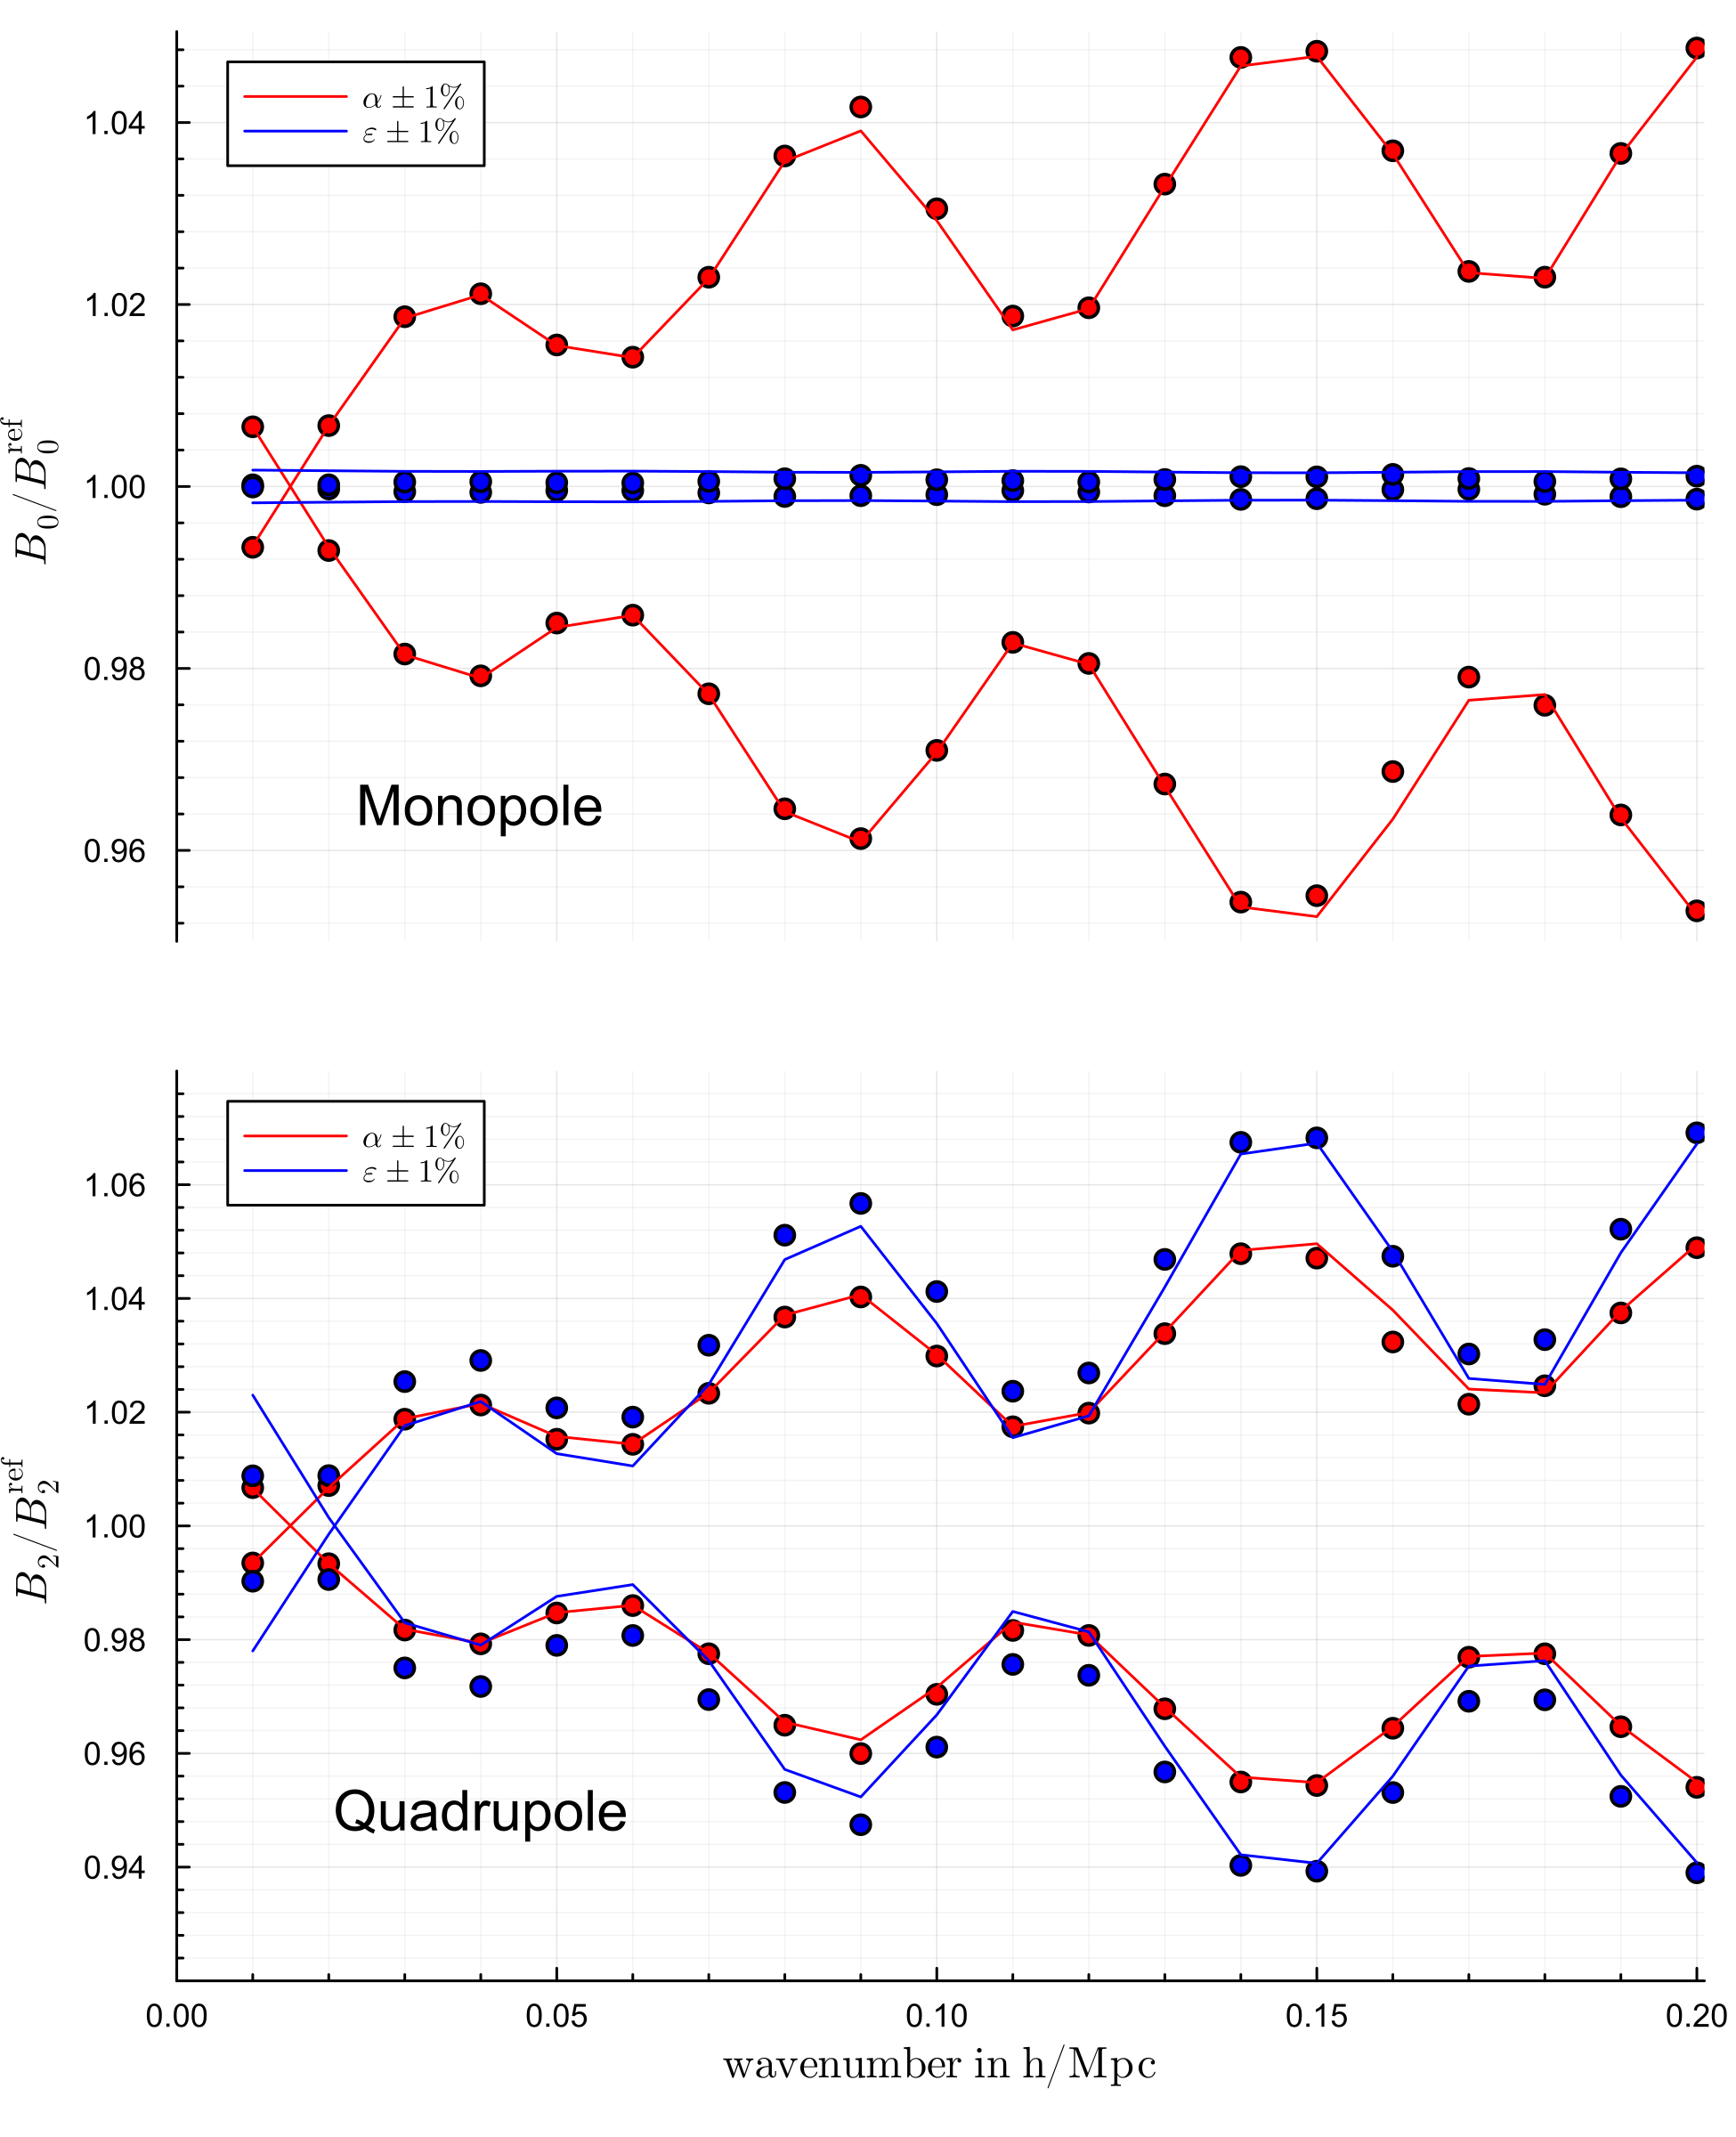

In [25]:
scatter(kgrid, b00list[1,:]./B00fid, label=:none, color=:red, layout=(2,1), size=(650, 800), dpi=300, subplot=1)
scatter!(kgrid, b00list[2,:]./B00fid, label=:none, color=:red, subplot=1)
scatter!(kgrid, b00list[3,:]./B00fid, label=:none, color=:blue, subplot=1)
scatter!(kgrid, b00list[4,:]./B00fid, label=:none, color=:blue, subplot=1)

plot!(kgrid, b00thlist[1,:]./B00fid, label=:none, color=:red, subplot=1)
plot!(kgrid, b00thlist[2,:]./B00fid, label=L"\alpha \pm 1\%", color=:red, subplot=1)
plot!(kgrid, b00thlist[3,:]./B00fid, label=:none, color=:blue, subplot=1)
plot!(kgrid, b00thlist[4,:]./B00fid, label=L"\epsilon \pm 1\%", color=:blue, subplot=1, legend=:topleft)

scatter!(kgrid, B20fid./b20list[1,:], label=:none, color=:red, subplot=2)
scatter!(kgrid, B20fid./b20list[2,:], label=:none, color=:red, subplot=2)
scatter!(kgrid, B20fid./b20list[3,:], label=:none, color=:blue, subplot=2)
scatter!(kgrid, B20fid./b20list[4,:], label=:none, color=:blue, subplot=2)

plot!(kgrid, B20fid./b20thlist[1,:], label=:none, color=:red, subplot=2)
plot!(kgrid, B20fid./b20thlist[2,:], label=L"\alpha \pm 1\%", color=:red, subplot=2)
plot!(kgrid, B20fid./b20thlist[3,:], label=:none, color=:blue, subplot=2)
plot!(kgrid, B20fid./b20thlist[4,:], label=L"\epsilon \pm 1\%", color=:blue, subplot=2, legend=:topleft)

plot!(xlabel=L"\textrm{wavenumber\ in\ h/Mpc}", ylabel=L"B_2/B^\mathrm{ref}_2", subplot=2)
plot!(ylabel=L"B_0/B^\mathrm{ref}_0", subplot=1)
plot!(xrange=(0,0.201), xaxis=:false, yrange=(0.95,1.05),grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true, subplot=1)
plot!(xrange=(0,0.201), yrange=(0.92,1.08), yticks=([0.94, 0.96, 0.98, 1.00, 1.02, 1.04, 1.06]), grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true, subplot=2)
annotate!(0.04, 0.965, "Monopole", fontfamily="Arial", subplot=1)
annotate!(0.04, 0.95, "Quadrupole", fontfamily="Arial", subplot=2)
#savefig("Bap.png")

In [20]:
b1 = b40(kgrid, kgrid, kgrid, 1.00, 1.00)
b2 = b40(kgrid, kgrid, kgrid, 1.00, 1.01)
b3 = b40(kgrid, kgrid, kgrid, 1.00, 0.99)

21-element Vector{Float64}:
 0.0
 8.550669104660365e7
 1.2557352954306456e8
 9.43963721323012e7
 5.426309895322688e7
 3.2674186815981746e7
 2.467810654561574e7
 2.167893158058873e7
 1.7715960173233032e7
 1.2306940178668229e7
 ⋮
 4.1157989874650054e6
 4.1035243675972847e6
 3.631007181976888e6
 2.616322643335839e6
 1.8454697467508684e6
 1.2782504533663036e6
 1.082942697763641e6
 1.1237107800931388e6
 1.0412004600992728e6

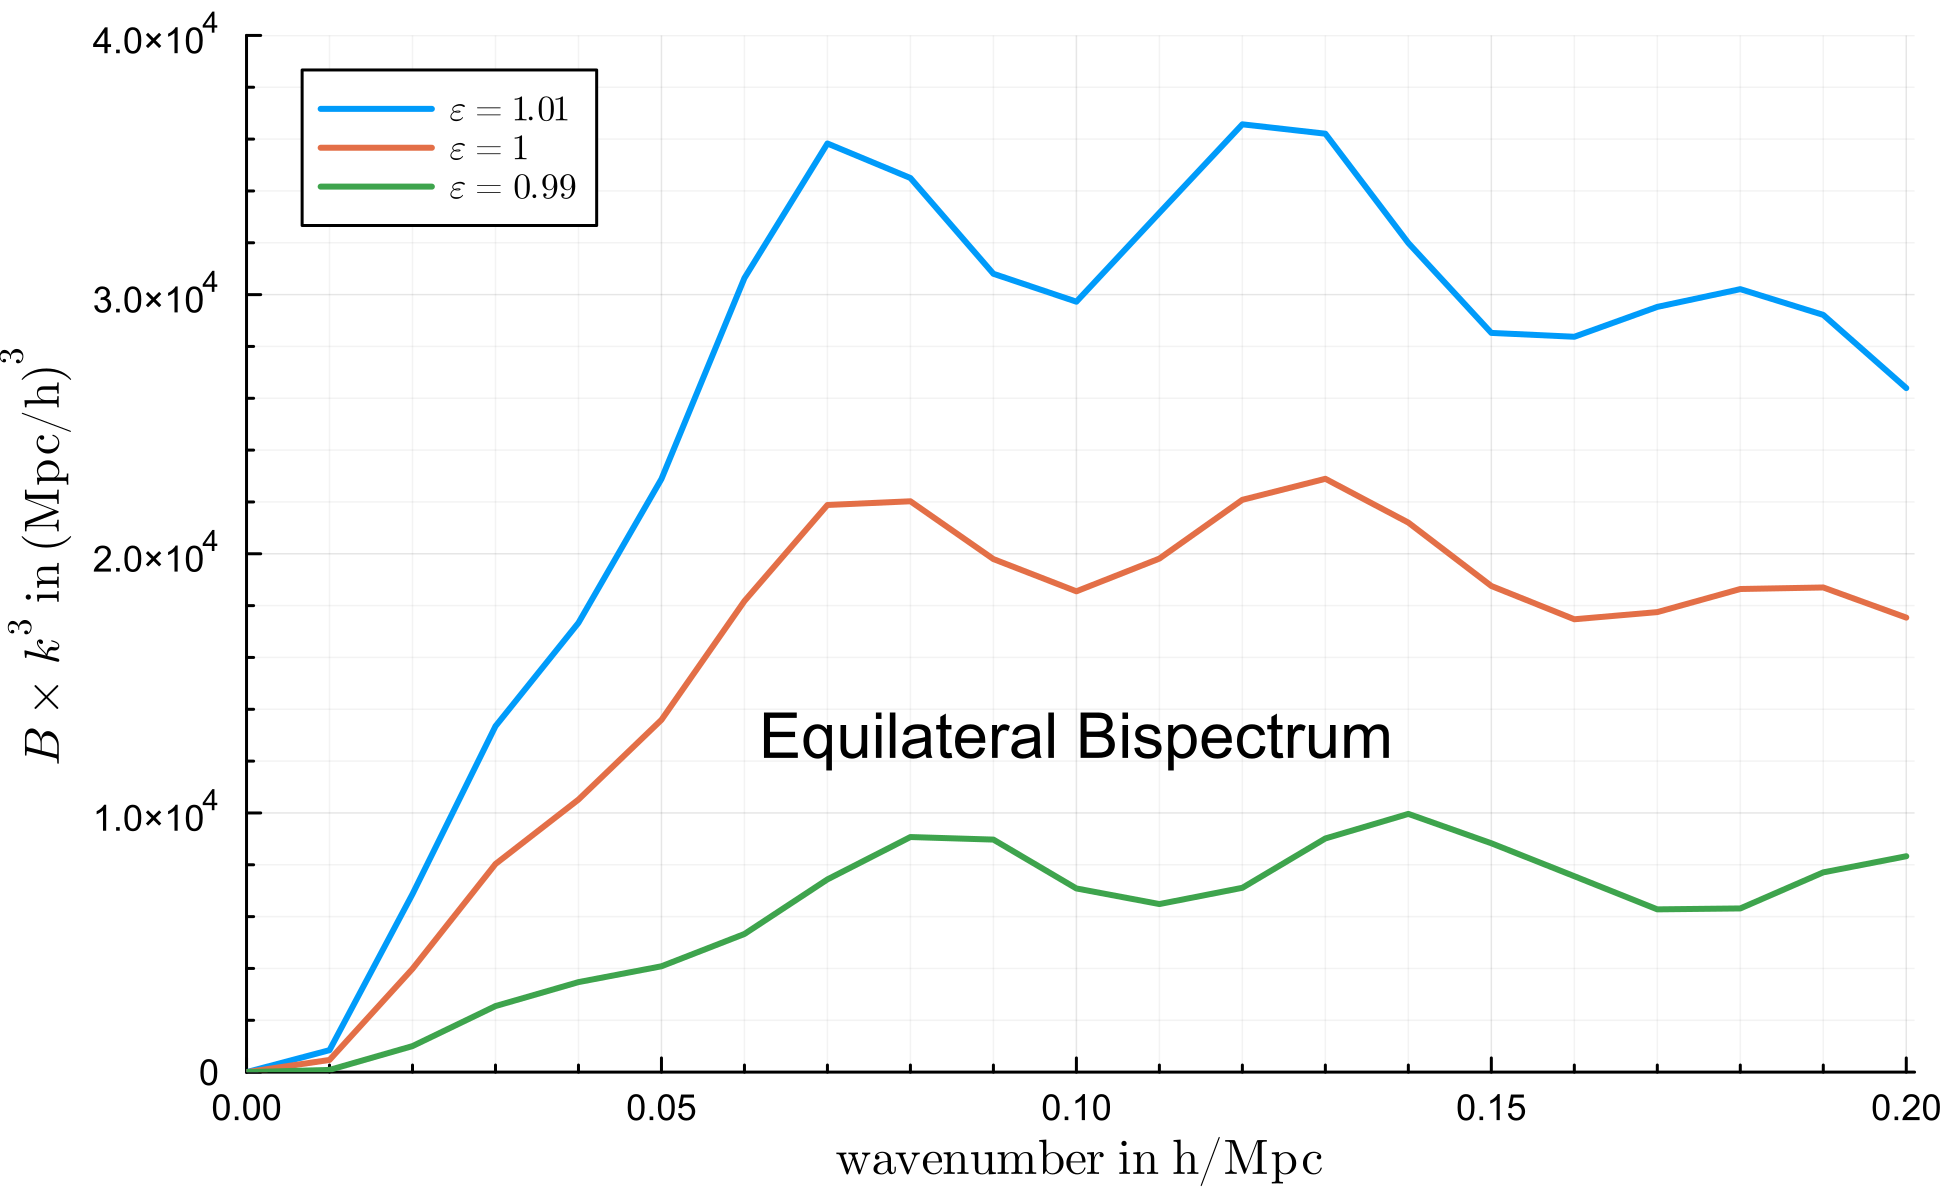

In [21]:
plot(kgrid, b2.*kgrid.^3, linewidth=2, label=L"$\epsilon = 1.01$")
plot!(kgrid, b1.*kgrid.^3, linewidth=2, label=L"$\epsilon = 1$")
plot!(kgrid, b3.*kgrid.^3, linewidth=2, label=L"$\epsilon = 0.99$")
plot!(xrange=(0,0.201),yrange=(0,40000),grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true)
plot!(xlabel=L"\textrm{wavenumber\ in\ h/Mpc}", ylabel=L"$B \times k^3\ \textrm{in\ (Mpc/h)}^3$")
plot!(size=(650, 400), dpi=300)
annotate!(0.10, 13000, "Equilateral Bispectrum", fontfamily="Arial")
#savefig("quadrupole.png")